# fMRI Analysis

Russ Poldrack, March 13, 2023

Note: The current notebook will not run on other machines without downloading the relevant data.  It's primarily meant for students to be able to follow along during the lecture.

Materials adapted from [Nilearn Examples](https://nilearn.github.io/stable/auto_examples/02_decoding/index.html)

In [36]:
import os
from pathlib import Path
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nilearn
import nilearn.plotting
from nilearn.glm.first_level import hemodynamic_models

import nibabel as nib

import sklearn
from sklearn.preprocessing import scale
from sklearn.decomposition import FastICA
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from spm_hrf import spm_hrf

from bids import BIDSLayout


## Data organization

The data are stored using a framework called the [Brain Imaging Data Structure](http://bids.neuroimaging.io), which provides a standard way to organize neuroimaging data.  These data can then be queried using the [PyBIDS](https://bids-standard.github.io/pybids/) Python tool.  

We will use the dataset from [Haxby et al., 2001](https://pubmed.ncbi.nlm.nih.gov/11577229/), which is available from [OpenNeuro](https://openneuro.org/datasets/ds000105).  Here are details about the data (from http://www.pymvpa.org/datadb/haxby2001.html):

> This is a block-design fMRI dataset from a study on face and object representation in human ventral temporal cortex. It consists of 6 subjects with 12 runs per subject. In each run, the subjects passively viewed greyscale images of eight object categories, grouped in 24s blocks separated by rest periods. Each image was shown for 500ms and was followed by a 1500ms inter-stimulus interval. Full-brain fMRI data were recorded with a volume repetition time of 2.5s, thus, a stimulus block was covered by roughly 9 volumes. This dataset has been repeatedly reanalyzed. For a complete description of the experimental design, fMRI acquisition parameters, and previously obtained results see the references below.


In [2]:
# set up data location for Haxby dataset from OpenNeuro

bids_dir = Path('/home/poldrack/data_unsynced/ds000105')

# use data for subject 1

subnum = 1
subdir = bids_dir / f'sub-{subnum}'
derivdir = bids_dir / f'derivatives/fmriprep'

layout = BIDSLayout(bids_dir)
print(layout)

BIDS Layout: ...oldrack/data_unsynced/ds000105 | Subjects: 6 | Sessions: 0 | Runs: 71


First we query for the anatomical image, which is used for overlaying the functional imaging data, and also to align individual brains to a common template.

In [3]:
anat_img = layout.get(subject=f'{subnum}', extension='nii.gz', suffix='T1w', return_type='filename')[0]
print('anatomical image:')
print(anat_img)
print()


anatomical image:
/home/poldrack/data_unsynced/ds000105/sub-1/anat/sub-1_T1w.nii.gz



These data are stored in a common image format known as *NifTI*, which is the main standard used for neuroimaging data in our field.

We can display the anatomical image using the [Nilearn](https://nilearn.github.io/stable/index.html) plotting tools:

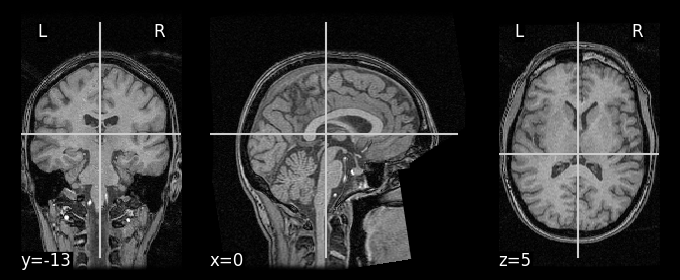

In [4]:
# set vmax to 200 to provide better contrast
nilearn.plotting.plot_anat(anat_img, vmax=200)

Now we query for the functional images.  There are twelve functional runs, so we should find 12 files.

In [5]:

func_imgs = layout.get(subject=f'{subnum}', extension='nii.gz', suffix='bold', return_type='filename')
print('functional images:')
for f in func_imgs: 
    print(f)

functional images:
/home/poldrack/data_unsynced/ds000105/sub-1/func/sub-1_task-objectviewing_run-01_bold.nii.gz
/home/poldrack/data_unsynced/ds000105/sub-1/func/sub-1_task-objectviewing_run-02_bold.nii.gz
/home/poldrack/data_unsynced/ds000105/sub-1/func/sub-1_task-objectviewing_run-03_bold.nii.gz
/home/poldrack/data_unsynced/ds000105/sub-1/func/sub-1_task-objectviewing_run-04_bold.nii.gz
/home/poldrack/data_unsynced/ds000105/sub-1/func/sub-1_task-objectviewing_run-05_bold.nii.gz
/home/poldrack/data_unsynced/ds000105/sub-1/func/sub-1_task-objectviewing_run-06_bold.nii.gz
/home/poldrack/data_unsynced/ds000105/sub-1/func/sub-1_task-objectviewing_run-07_bold.nii.gz
/home/poldrack/data_unsynced/ds000105/sub-1/func/sub-1_task-objectviewing_run-08_bold.nii.gz
/home/poldrack/data_unsynced/ds000105/sub-1/func/sub-1_task-objectviewing_run-09_bold.nii.gz
/home/poldrack/data_unsynced/ds000105/sub-1/func/sub-1_task-objectviewing_run-10_bold.nii.gz
/home/poldrack/data_unsynced/ds000105/sub-1/func/su

These images are 4-dimensional. We can load their data using the [Nibabel](https://nipy.org/nibabel/) library and inspect its contents:

In [6]:
func_img = nib.load(func_imgs[0])
func_data = func_img.get_fdata()

func_data.shape

(40, 64, 64, 121)

The data comprise 121 three-dimensional images; the three dimensions refer to left/right, up/down, and front/back. 

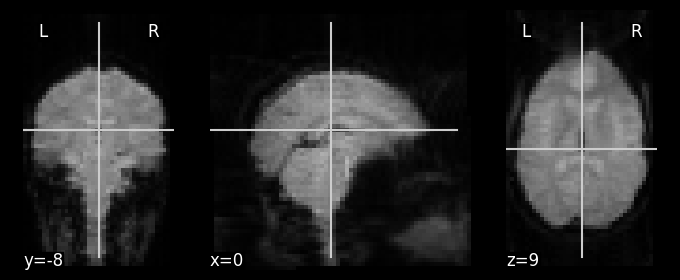

In [7]:
nilearn.plotting.plot_anat(nilearn.image.index_img(func_imgs[0], 0))

## Task information

In order to analyze the fMRI data we need to also load the information regarding which stimuli were presented at which times.  These are stored according to the BIDS standard in an "events.tsv" associated with each task run.  The standard format has three columns that specify the onset of each event (in seconds from the beginning of the run), the duration of the event (in seconds), and a variable called `trial_type` that specifies the experimental condition.



In [8]:
event_files = layout.get(subject=f'{subnum}', extension='tsv', suffix='events', return_type='filename')

events = {}
for f in event_files:
    run_num = f.split('_')[-2]
    events[run_num] = pd.read_csv(f, sep='\t')

print(f'Found {len(events)} event files')

events[run_num].head()

Found 12 event files


,onset,duration,trial_type
0,12.0,0.5,bottle
1,14.0,0.5,bottle
2,16.0,0.5,bottle
3,18.0,0.5,bottle
4,20.0,0.5,bottle


There should be 8 different object types presented in each run:

In [9]:
conditions = events[run_num].trial_type.unique()
print(conditions)

['bottle' 'house' 'chair' 'scrambledpix' 'face' 'shoe' 'cat' 'scissors']


## Analyzing the data using the general linear model (GLM)

The standard approach to anlyzing task fMRI data is to model each experimental condition as a regressor in a general linear model.  

Let's create a design matrix that specifies these regressors.

In [10]:
# get info about timeseries length

n_timepoints = func_img.dataobj.shape[3]
print(n_timepoints, 'timepoints')

# get the length of each image acquisition, known as repetition time or TR
TR = func_img.header.get_zooms()[3]
print('TR:', TR)

121 timepoints
TR: 2.5


We will now create the design matrix for each run, saving each to a dictionary indexed by the run label.  We will actually create two design matrices: one is an untransformed representation of the task as a boxcar (with ones during task blocks for each condition and zeros otherwise). We will discuss the second design matrix below.

In [11]:

desmtx = {}
desmtx_conv = {}

# onset times for each timepoint, in seconds
frame_times = np.arange(0, n_timepoints * TR, TR)

# length of each task block, in seconds
block_length = 24

for run_num, event_df in events.items():
    # first create empty design matrices, to be filled below
    desmtx[run_num] = np.zeros((n_timepoints, len(conditions) ))
    desmtx_conv[run_num] = np.zeros(desmtx[run_num].shape)
    
    for i, cond in enumerate(conditions):
        # create a single block instead of using individual events
        cond_events = events[run_num].query(f'trial_type == "{cond}"')[['onset','duration']]
        cond_events['amplitude'] = 1
        # set the first event to the block length, and then remove the rest
        cond_events.iloc[0, 1] = block_length
        cond_events = cond_events.iloc[0, :]
        
        # create the unconvolved design matrix
        desmtx[run_num][:, i] = hemodynamic_models.compute_regressor(
                            cond_events.to_numpy()[:, np.newaxis],
                            None, frame_times, oversampling=50)[0][:, 0]
        
        # create the design matrix convolved with the SPM hemodynamic response
        desmtx_conv[run_num][:, i] = hemodynamic_models.compute_regressor(
                            cond_events.to_numpy()[:, np.newaxis],
                            'spm', frame_times, oversampling=50)[0][:, 0]

It is customary to display the design matrix as a image, with timepoints on the vertical axis and conditions on the horizontal axis.  In this case, the white blocks represent ones and the black areas represent zeros.

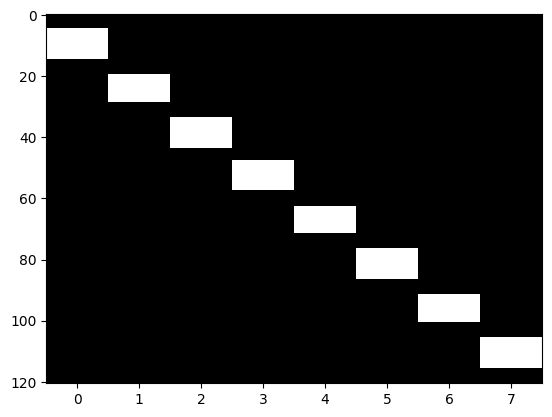

In [12]:
plt.imshow(desmtx[run_num], aspect='auto', cmap='gray')

We can also plot these as timeseries, which shows that each has a boxcar form:

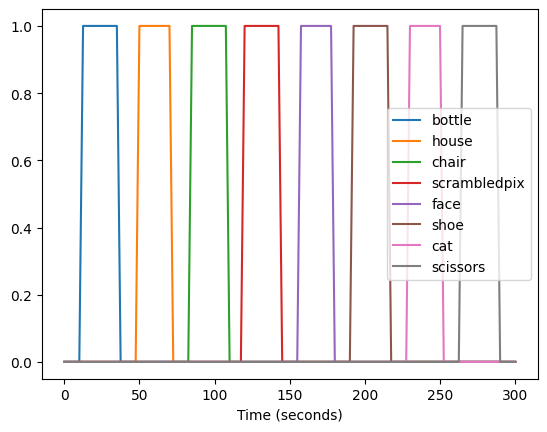

In [13]:
_ = plt.plot(frame_times, desmtx[run_num])
plt.xlabel('Time (seconds)')
plt.legend(conditions)

### Hemodynamic convolution

The standard fMRI technique (known as *Blood Oxygen Level Dependent* or *BOLD* fMRI) measures changes in MRI signal related to changes in blood oxygen levels, which increase locally when neural activity increases (specifically, when synaptic input increases).  This blood flow response is relatively slow, unfolding over seconds.  Here is an example from our Handbook of fMRI Data Analysis:

> An example of the hemodynamic responses evoked in area V1 by a contrast-
reversing checkerboard displayed for 500 ms. The four different lines are data from four
different individuals, showing how variable these responses can be across people. The
MRI signal was measured every 250 ms, which accounts for the noisiness of the plots.
(Data courtesy of Stephen Engel, University of Minnesota)

![](images/hrf.png)


Because of this hemodynamic delay, we don't expect the BOLD response to stimuli to follow a boxcar function. Rather, we expect that they will be lagged and smeared.  Fortunately, there is good evidence to think that the BOLD response is relatively linear (at least for stimul in the range of 0.5-2 secs), so we can simply convolve our boxcar function with a function that represents the shape of the hemodynamic response.  One commonly used function is known as the *SPM HRF* since it is used in the popular SPM software package.  It is a combination of two gamma functions, one that models the positive response and a second that models a slower negative response. 

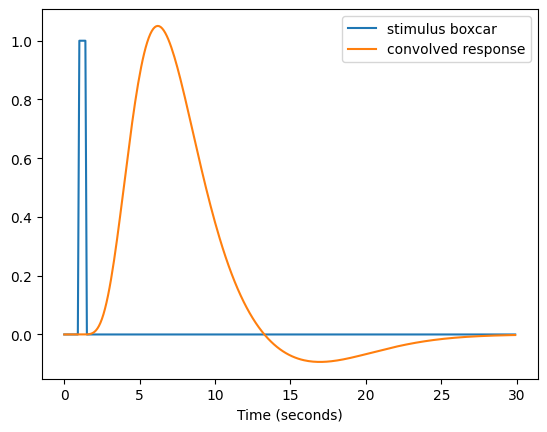

In [14]:
# convolve with hemodynamic response

# boxcar with 100 ms resolution

timepoints = np.arange(0, 30, 0.1)

boxcar = np.zeros(len(timepoints)) # 30 second window
boxcar[10:15] = 1 # 500 ms stimulus starting at 1 second
plt.plot(timepoints, boxcar)
plt.xlabel('Time (seconds)')

# magnify the convolved response by 10 for display purposes
convolved_resp = np.convolve(boxcar, spm_hrf(0.1), mode='full')[:len(timepoints)] * 10
plt.plot(timepoints, convolved_resp)
plt.legend(['stimulus boxcar', 'convolved response'])

Now let's plot the boxcar function and convolved regressors for one of the Haxby runs.

Text(0.5, 0, 'Time (secs)')

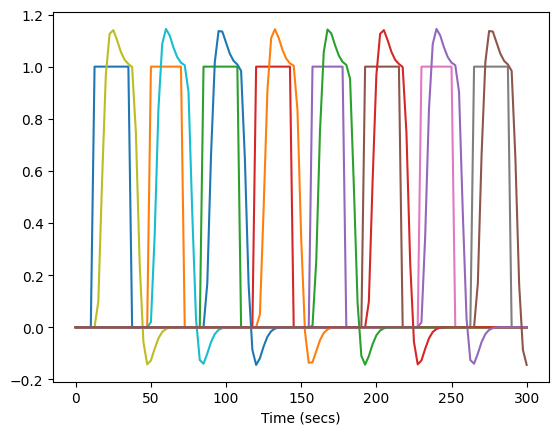

In [15]:
_ = plt.plot(frame_times, desmtx[run_num])
_ = plt.plot(frame_times, desmtx_conv[run_num])
plt.xlabel('Time (secs)')

## FMRI data preprocessing

We now wish to fit the GLM to data from each run.  However, before the fMRI data can be analyzed, they need to be *preprocessed* to address several issues:

- We need to estimate and correct for head motion across each scan
- We need to estimate a number of other potentia confounding signals, such as physiological fluctuations that relate to breathing or heartbeat, or residual effects of head motion.
- We often want to align each individual's brain with a common template, so that data can be combined across individuals.

To accomplish this we use the [fMRIPrep](http://fmriprep.org) preprocessing workflow:

![](images/fmriprep.jpg)


(quick tour through the fMRIPrep diagnostic outputs)

fMRIPrep stores its outputs (known generically as *derivatives*) in a BIDS format that can also be queried using PyBIDS.  Lets find the preprocessed BOLD data (which have been transformed into a common template space known as *MNI152NLin2009cAsym*), and also find the mask images that tell us for each image which voxels fall within the brain.

In [16]:
# use fmriprepped data
fmriprep_layout = BIDSLayout(derivdir)

# get a common mask across runs
maskfiles = fmriprep_layout.get(subject=f'{subnum}', extension='nii.gz', datatype='func', suffix='mask', return_type='filename')
all_masks = nilearn.image.concat_imgs(maskfiles)
mask = nilearn.image.threshold_img(nilearn.image.mean_img(all_masks), 1.0)

# find all of the preprocessed BOLD images
boldfiles = fmriprep_layout.get(subject=f'{subnum}', extension='nii.gz', datatype='func', suffix='bold', return_type='filename')
meanbold = nilearn.image.mean_img(boldfiles)

Overlay the common mask across runs on top of the subject's anatomical image,  this lets you see the areas where fMRI data are missing due to "dropout":

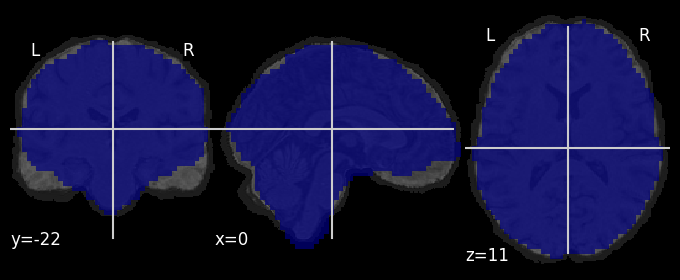

In [17]:
bg_image = fmriprep_layout.get(subject=f'{subnum}', space='MNI152NLin2009cAsym',
                                   extension='nii.gz', datatype='anat', suffix='T1w', 
                                   return_type='filename')[0]


nilearn.plotting.plot_roi(mask, bg_img=bg_image)

Load the data from the in-mask voxels for each run, storing them to a dictionary indexed by runs. Since processed in the data in 3D is inconvenient, we will use the Nilearn `NiftiMasker` to extract the data from all of the in-mask voxels and return them as a 2D (timepoints X voxels) matrix.  We will also load and store a set of *confound regressors* that are computed by fMRIPrep; these include several estimates of head motion, along with the first 8 principal components of signal from within regions not expected to show BOLD activation, such as the ventricles.  The NiftiMasker can then remove these confounds from the data.

In [18]:
# create both full and deconfounded versions of each dataset
bolddata = {}
bolddata_deconfounded = {}
confounds = {}

masker = nilearn.maskers.NiftiMasker(mask)

# confounds include 
# - framewise displacement (total motion)
# - acompcor (principal components of signals from nuisance areas)
# - estimated motion params (translation and rotation and their derivatives
# cosine bases (modeling low-frequency trends

confound_vars = ['framewise_displacement'] + [f'a_comp_cor_0{i}' for i in range(8)]
confound_vars += [f'trans_{d}' for d in ['x', 'y', 'z']]
confound_vars += [f'rot_{d}' for d in ['x', 'y', 'z']]
confound_vars += [f'trans_{d}_derivative1' for d in ['x', 'y', 'z']]
confound_vars += [f'rot_{d}_derivative1' for d in ['x', 'y', 'z']]
confound_vars += [f'cosine0{i}' for i in range(3)]
                  
for run_num, X in desmtx_conv.items():
    print(f'loading data for {run_num}')
    
    confound_file = fmriprep_layout.get(subject=f'{subnum}', run=int(run_num.split('-')[1]), 
                                   extension='tsv', datatype='func', suffix='timeseries', 
                                   return_type='filename')[0]
    full_confounds = pd.read_csv(confound_file, sep='\t')
    confounds[run_num] = full_confounds[confound_vars].fillna(0)

    boldfile = fmriprep_layout.get(subject=f'{subnum}', run=int(run_num.split('-')[1]), 
                                   extension='nii.gz', datatype='func', suffix='bold', 
                                   return_type='filename')[0]
    bolddata[run_num] = masker.fit_transform(boldfile)
    bolddata_deconfounded[run_num] = masker.fit_transform(boldfile, confounds=confounds[run_num])


loading data for run-01
loading data for run-02
loading data for run-03
loading data for run-04
loading data for run-05
loading data for run-06
loading data for run-07
loading data for run-08
loading data for run-09
loading data for run-10
loading data for run-11
loading data for run-12


Combine the data across runs and fit the statistical model, with a separate intercept for each run.

In [19]:
bolddata_concat = None
bolddata_deconfounded_concat = None

X_concat = None

run_idx = 0
for run_num, rundata in bolddata.items():
    if bolddata_concat is None:
        bolddata_concat = bolddata[run_num]
        bolddata_deconfounded_concat = bolddata_deconfounded[run_num]
        X_concat = np.concatenate((desmtx_conv[run_num], confounds[run_num]), axis=1)
    else:
        bolddata_deconfounded_concat = np.concatenate((bolddata_deconfounded_concat, 
                                                       bolddata_deconfounded[run_num]))
        bolddata_concat = np.concatenate((bolddata_concat, bolddata[run_num]))
        X_concat = np.concatenate((X_concat, 
            np.concatenate((desmtx_conv[run_num], confounds[run_num]), axis=1)))
    
# make intercepts for each run
nruns = len(bolddata)
intercept_mtx = None

for i in range(nruns):
    run_intercept = np.zeros((n_timepoints, nruns))
    run_intercept[:, i] = 1
    if intercept_mtx is None:
        intercept_mtx = run_intercept
    else:
        intercept_mtx = np.concatenate((intercept_mtx, run_intercept))
        
X_concat = np.append(X_concat, intercept_mtx, axis=1)

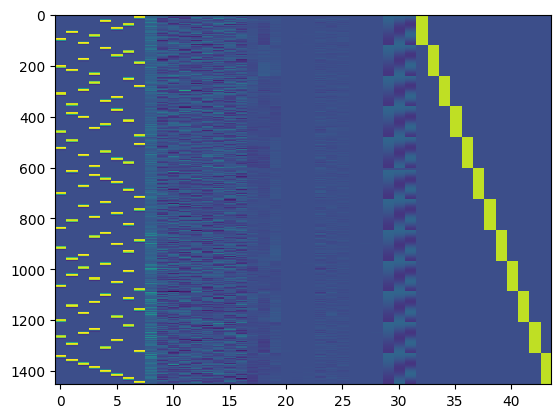

In [20]:
plt.imshow(X_concat, aspect='auto', interpolation='nearest')

Use the design matrix to fit the model to the non-denoised data, and compute the t/p values for each condition as well as the overall r-squared for the full model.

In [21]:
lm = LinearRegression()
lm.fit(X_concat, bolddata_concat)

# compute t/p values for each of the condition regressors
# from https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression

sse = np.sum((lm.predict(X_concat) - bolddata_concat) ** 2, axis=0) / float(X_concat.shape[0] - X_concat.shape[1])
se = np.array([
    np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X_concat.T, X_concat))))
                                            for i in range(sse.shape[0])
            ])

t = lm.coef_ / se
p = 2 * (1 - scipy.stats.t.cdf(np.abs(t), bolddata[run_num].shape[0] - X_concat.shape[1]))    

# compute r-squared for the full model
rsquared_full = sklearn.metrics.r2_score(bolddata_concat, lm.predict(X_concat),
                                       multioutput='raw_values')

# stored the fitted response
fitted_resp_full = lm.predict(X_concat)

In [22]:
# also fit the model for the confounds only and compute r-squared for each voxel

X_confound = X_concat[:, 8:]
lm.fit(X_confound, bolddata_concat)
rsquared_confound = sklearn.metrics.r2_score(bolddata_concat, lm.predict(X_confound),
                                       multioutput='raw_values')
rsquared_confound_img = masker.inverse_transform(rsquared_confound)


If we plot the r-squared for the confound model, we see that it accounts for a large amount of variance across much of the brain, especially near the edges, where motion is particularly impactful.

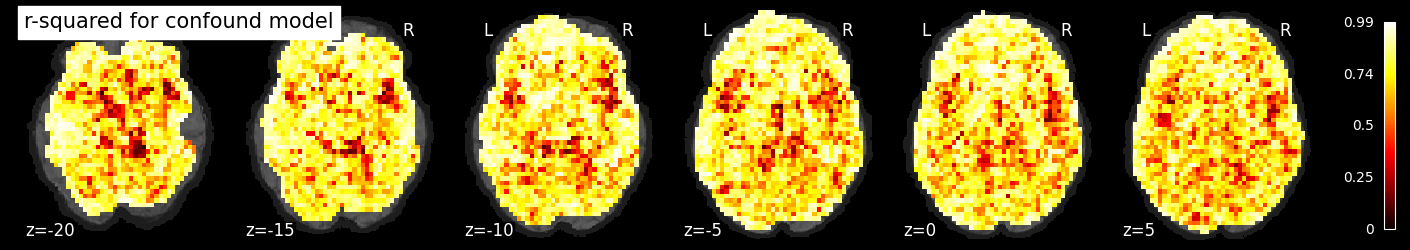

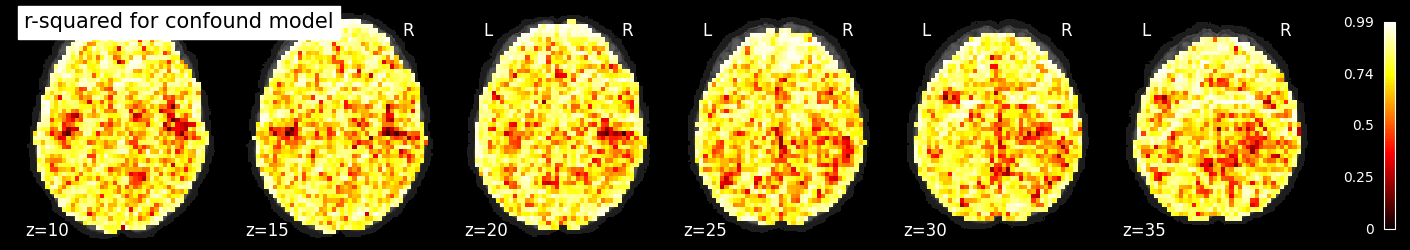

In [23]:
nilearn.plotting.plot_stat_map(rsquared_confound_img, bg_image, title='r-squared for confound model',
                              display_mode='z', cut_coords=np.arange(-20, 10, 5))
nilearn.plotting.plot_stat_map(rsquared_confound_img, bg_image, title='r-squared for confound model',
                              display_mode='z', cut_coords=np.arange(10, 40, 5))


To see the added variance accounted for by the task model, we can compute the incremental r-squared, which we see is much more isolated.

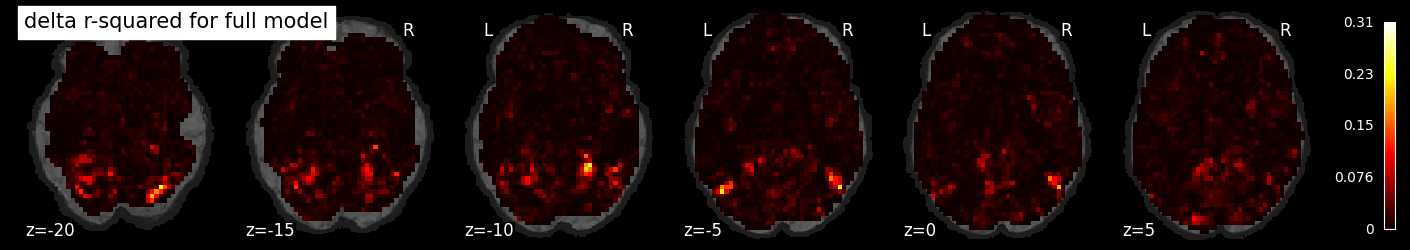

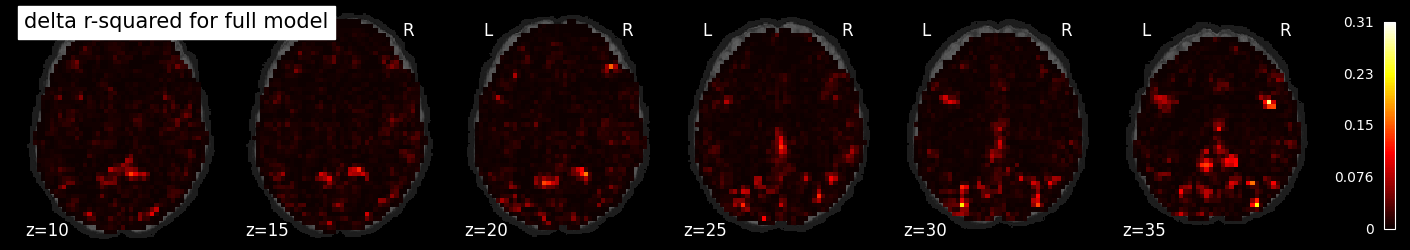

In [24]:
incremental_rsquared_img = masker.inverse_transform(rsquared_full - rsquared_confound)

nilearn.plotting.plot_stat_map(incremental_rsquared_img, bg_image, title='delta r-squared for full model',
                              display_mode='z', cut_coords=np.arange(-20, 10, 5))
nilearn.plotting.plot_stat_map(incremental_rsquared_img, bg_image, title='delta r-squared for full model',
                              display_mode='z', cut_coords=np.arange(10, 40, 5))


We can also visualize the statistical maps associated with each condition.  We will use the false discovery rate as a rough control for Type I error across the brain, but note that concerns have been raised about the use of FDR in spatially autocorrelated maps like fMRI data ([Chumbley & Friston, 2009](https://pubmed.ncbi.nlm.nih.gov/18603449/)).

In [25]:
tmaps = {}

alpha = .001

# convert the 8 condition images back to nifti
for i, cond in enumerate(conditions):
    tmaps[cond] = nilearn.glm.threshold_stats_img(
        masker.inverse_transform(t[:, i]),
        alpha=alpha,
        cluster_threshold=20,
        height_control='fdr')[0]
        

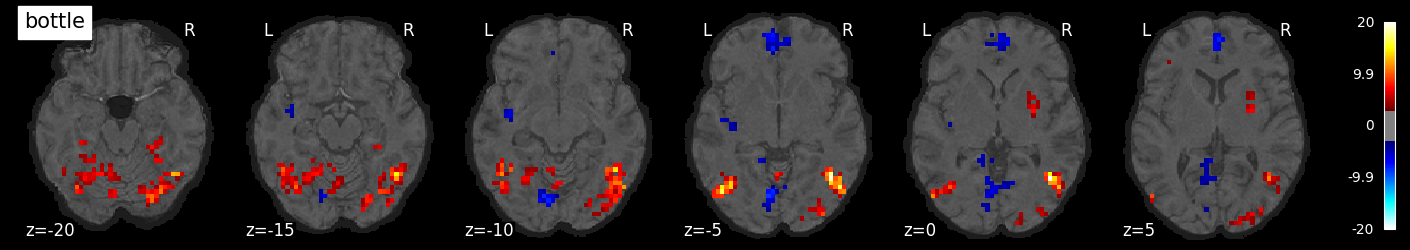

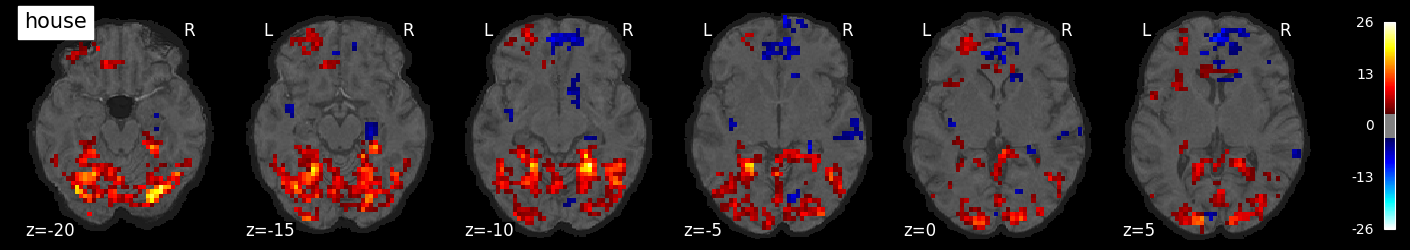

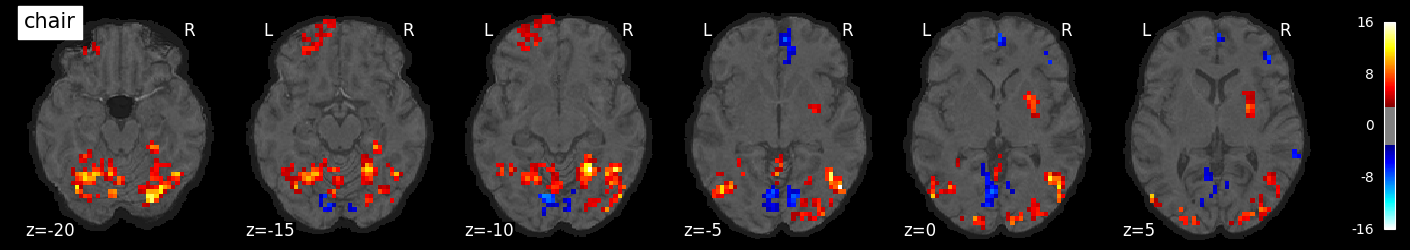

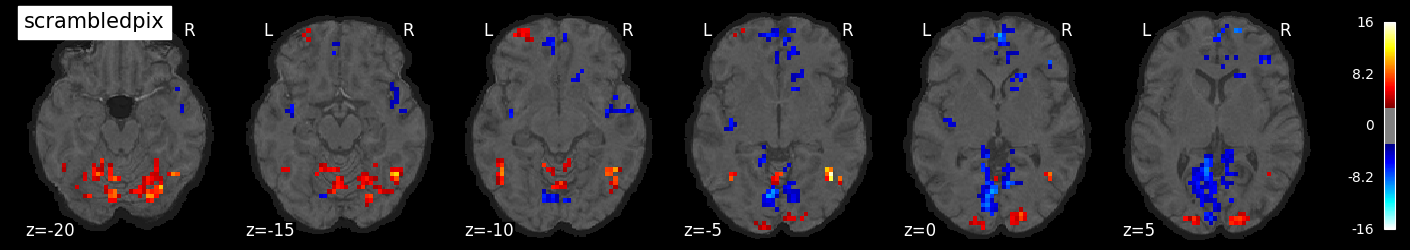

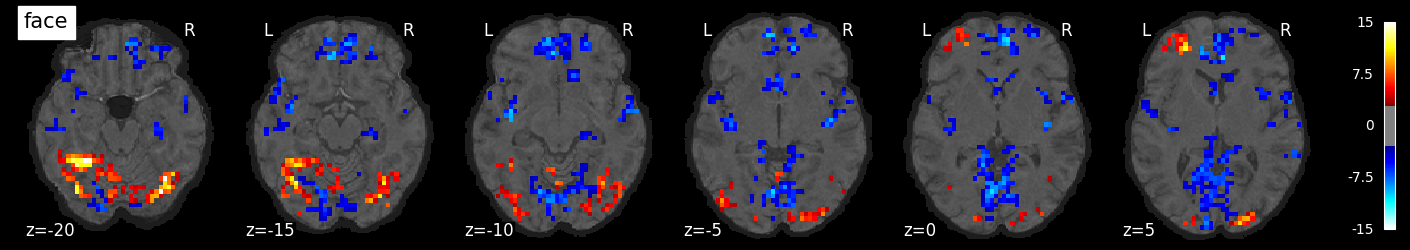

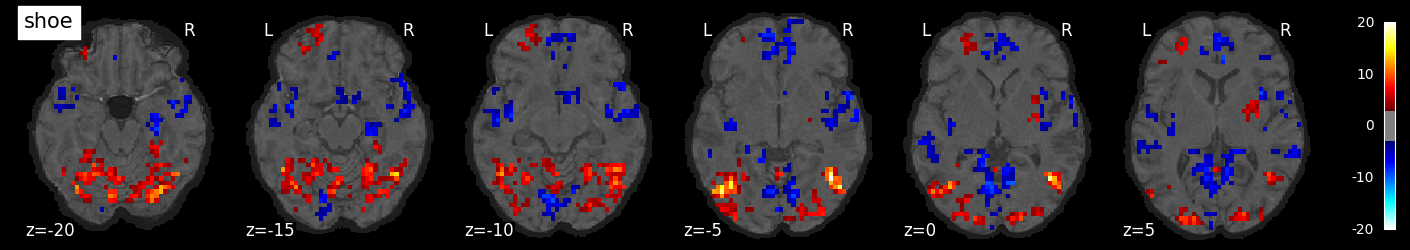

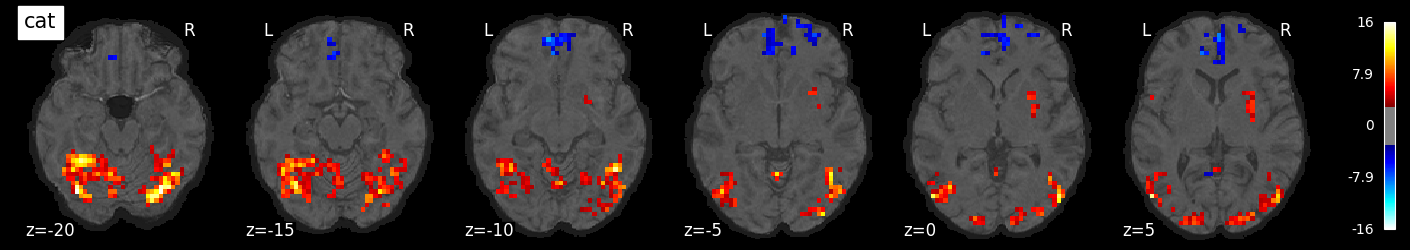

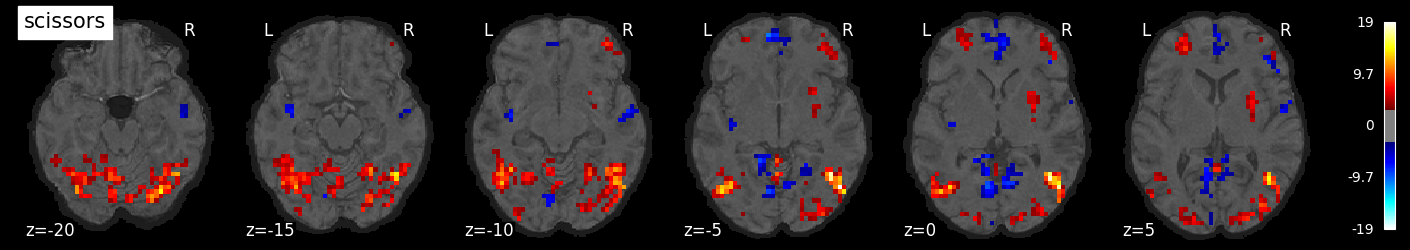

In [26]:
# plot the images
if not os.path.exists('tmaps'):
    os.mkdir('tmaps')
    
for i, cond in enumerate(conditions):
    nilearn.plotting.plot_stat_map(tmaps[cond], bg_image, threshold=3.0, title=cond,
                                  display_mode='z', cut_coords=np.arange(-20, 10, 5))
    tmaps[cond].to_filename(f'tmaps/{cond}_tmap.nii.gz')
    

Examine the timeseries from a region of interest

Text(0.5, 1.0, 'Face voxel (r-squared = 0.61)')

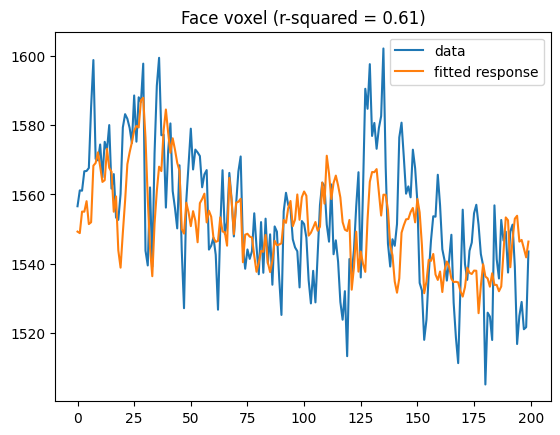

In [27]:
# find highest activating voxel for faces
face_regressor_idx = np.where(conditions == 'face')[0][0]
facevox = np.argmax(t[:, face_regressor_idx])

plt.plot(bolddata_concat[:200, facevox])
plt.plot(fitted_resp_full[:200, facevox])
plt.legend(['data', 'fitted response'])
plt.title(f'Face voxel (r-squared = {rsquared_full[facevox]:0.2f})')


Text(0.5, 1.0, 'Face voxel (r-squared = 0.62)')

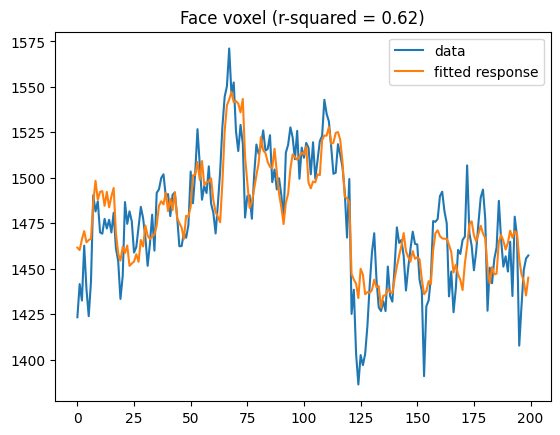

In [28]:
# find highest activating voxel for houses
house_regressor_idx = np.where(conditions == 'house')[0][0]
housevox = np.argmax(t[:, house_regressor_idx])

plt.plot(bolddata_concat[:200, housevox])
plt.plot(fitted_resp_full[:200, housevox])
plt.legend(['data', 'fitted response'])
plt.title(f'Face voxel (r-squared = {rsquared_full[housevox]:0.2f})')


## Classifying stimuli using fMRI response

So far we have looked at an encoding model; we will now turn to a decoding model, in which we try to classify the stimulus class being observed in paticular block using the weighted-average BOLD response within the block.

We first need run the model separately within each run, to get the response in each voxel to each condition, which we will use as our signal estimate for crossvalidation across runs.

In [29]:
model_coefs = {}

for run_num, rundata in bolddata.items():
    X = np.concatenate((desmtx_conv[run_num], confounds[run_num]), axis=1)
    lm = LinearRegression(fit_intercept=True)
    lm.fit(X, bolddata[run_num])
    model_coefs[run_num] = lm.coef_[:, :8].T

Here we create a function to perform cross-validated classification using a leave-one-run-out approach.  One would not want to split across data within a run, since there can be strong correlations within runs.

In [30]:
# use leave-one-run-out crossvalidation to fit and test classifier
def run_classifier(model_coefs, conditions, clf=None, fsel=None, p_thresh=.01):
    """
    combine data and performing classification using Leave-one-run-out
    """
    
    if clf is None:
        clf = LinearSVC()
    
    cv = sklearn.model_selection.LeaveOneOut()
    
    true_y = []
    pred_y = []
    selected_prob = None
    nruns = len(model_coefs)
    
    for i, (train_index, test_index) in enumerate(cv.split(np.ones((nruns,1)))):
        # put together the train data from the individual runs
        # and test data from held-out run
        train_X = None
        train_y = None
        test_X = None
        test_y = None
        for idx in train_index:
            if train_X is None:
                train_X = model_coefs[f'run-{idx + 1:02d}']
                train_y = list(conditions)
            else:
                train_X = np.concatenate((train_X, model_coefs[f'run-{idx + 1:02d}']))
                train_y += list(conditions)
        for idx in test_index:
            if test_X is None:
                test_X = model_coefs[f'run-{idx + 1:02d}']
                test_y = list(conditions)
            else:
                test_X = np.concatenate((test_X, model_coefs[f'run-{idx + 1:02d}']))
                test_y += list(conditions)
        
        if fsel == 'f_classif':
            f, p = f_classif(train_X, train_y)
            selected_features = (p < p_thresh).astype('int')
            if selected_prob is None:
                selected_prob = selected_features
            else:
                selected_prob = selected_prob + selected_features
            print(f'selected {sum(selected_features)} features')
            train_X = train_X[:, selected_features == 1]
            test_X = test_X[:, selected_features == 1]
            
        scaler = sklearn.preprocessing.StandardScaler()
        train_X_scaled = scaler.fit_transform(train_X)
        clf.fit(train_X, train_y)
        true_y += test_y
        
        pred_y += list(clf.predict(scaler.transform(test_X)))
    if selected_prob is not None:
        selected_prob = selected_prob / nruns
    print("balanced accuracy:", sklearn.metrics.balanced_accuracy_score(true_y, pred_y))
    return (true_y, pred_y, selected_prob)

Run on whole-brain data with no feature selection

In [31]:
true_y, pred_y, _ = run_classifier(model_coefs, conditions)

balanced accuracy: 0.45833333333333326


In [32]:
conf_mtx = pd.DataFrame(
    sklearn.metrics.confusion_matrix(true_y, pred_y),
    columns=conditions,
    index=conditions)
conf_mtx

,bottle,house,chair,scrambledpix,face,shoe,cat,scissors
bottle,5,1,4,1,0,0,0,1
house,1,2,3,3,0,1,1,1
chair,3,1,2,0,0,3,1,2
scrambledpix,0,1,0,11,0,0,0,0
face,0,0,1,0,11,0,0,0
shoe,3,0,0,0,0,3,3,3
cat,0,0,0,1,1,2,8,0
scissors,2,1,2,0,0,4,1,2


Run using feature selection based on F statistic across all categories

In [33]:
true_y, pred_y, selected_prob = run_classifier(model_coefs, conditions, 
                                               fsel='f_classif')

conf_mtx = pd.DataFrame(
    sklearn.metrics.confusion_matrix(true_y, pred_y),
    columns=conditions,
    index=conditions)
conf_mtx

selected 1186 features
selected 1204 features
selected 1177 features
selected 1201 features
selected 1271 features
selected 1137 features
selected 1093 features
selected 1243 features
selected 1364 features
selected 1144 features
selected 1233 features
selected 1167 features
balanced accuracy: 0.75


,bottle,house,chair,scrambledpix,face,shoe,cat,scissors
bottle,8,0,1,0,0,2,1,0
house,1,10,0,1,0,0,0,0
chair,2,2,5,0,0,2,0,1
scrambledpix,0,1,0,11,0,0,0,0
face,0,0,0,0,12,0,0,0
shoe,4,0,0,0,0,8,0,0
cat,0,0,0,1,0,0,11,0
scissors,2,0,0,0,0,3,0,7


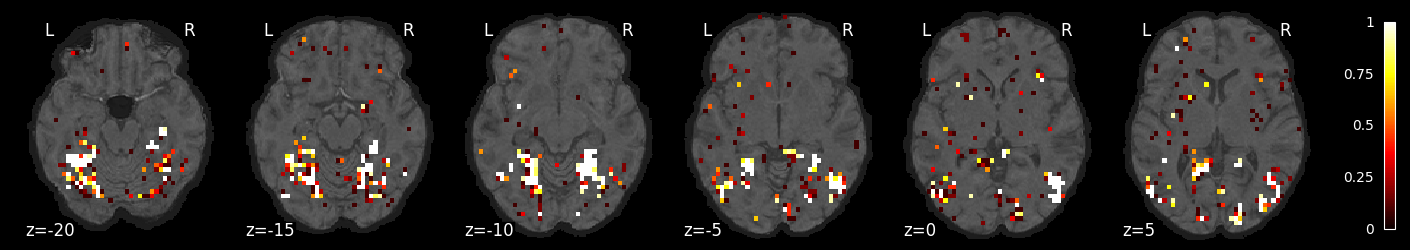

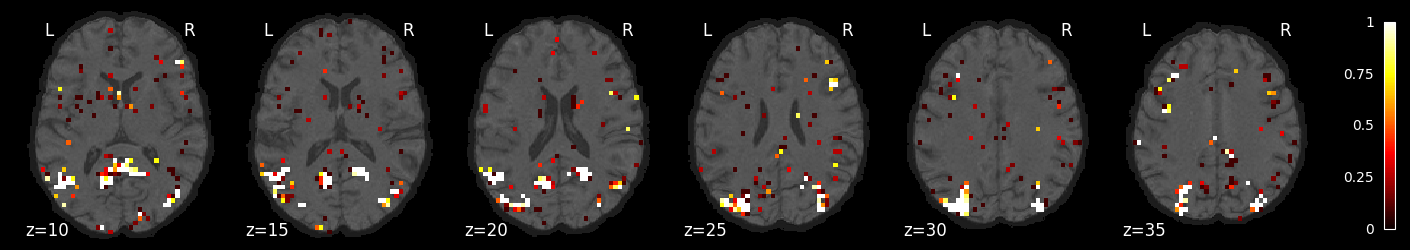

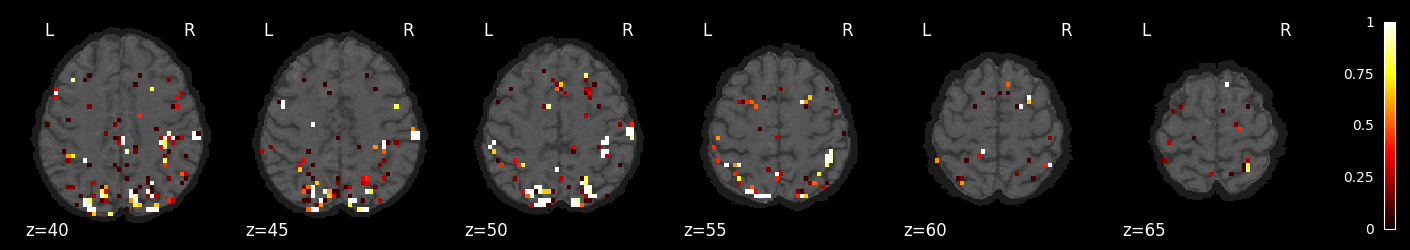

In [34]:
feature_selection_img = masker.inverse_transform(selected_prob)

nilearn.plotting.plot_stat_map(feature_selection_img, bg_image, threshold=.01,
                              display_mode='z', cut_coords=np.arange(-20, 10, 5))
nilearn.plotting.plot_stat_map(feature_selection_img, bg_image, threshold=.01,
                              display_mode='z', cut_coords=np.arange(10, 40, 5))
nilearn.plotting.plot_stat_map(feature_selection_img, bg_image, threshold=.01,
                              display_mode='z', cut_coords=np.arange(40, 70, 5))


Try a different classifier: SGD with grid search over penalties and losses

In [37]:
svc_clf = GridSearchCV(SGDClassifier(), 
                      param_grid={'loss': ['hinge', 'log_loss', 'modified_huber'],
                                  'penalty': ['l2', 'l1', 'elasticnet'],
                                  'alpha': [1e-6, 1e-6, 1e-4, 1e-3, 1e-2]})

true_y, pred_y, _ = run_classifier(model_coefs, conditions, clf=svc_clf, fsel='f_classif')
conf_mtx = pd.DataFrame(
    sklearn.metrics.confusion_matrix(true_y, pred_y),
    columns=conditions,
    index=conditions)
conf_mtx


selected 1186 features
selected 1204 features
selected 1177 features
selected 1201 features
selected 1271 features
selected 1137 features
selected 1093 features
selected 1243 features
selected 1364 features
selected 1144 features
selected 1233 features
selected 1167 features
balanced accuracy: 0.6875


,bottle,house,chair,scrambledpix,face,shoe,cat,scissors
bottle,4,1,1,0,0,4,1,1
house,0,9,0,3,0,0,0,0
chair,1,3,4,0,0,1,2,1
scrambledpix,0,1,0,11,0,0,0,0
face,0,0,0,0,12,0,0,0
shoe,2,0,1,0,0,8,0,1
cat,0,0,0,0,0,2,10,0
scissors,1,0,0,0,0,2,1,8


## Unsupervised learning

### Dimensionality reduction 

First let's project the data from task-relevant voxels into a low-dimensional space using PCA or T-SNE.

In [38]:
# put all contrast images into a single dataset

all_X = None
all_y = None

for idx in range(len(bolddata)):
    if all_X is None:
        all_X = model_coefs[f'run-{idx + 1:02d}']
        all_y = list(conditions)
    else:
        all_X = np.concatenate((all_X, model_coefs[f'run-{idx + 1:02d}']))
        all_y += list(conditions)


f, p = f_classif(all_X, all_y)
p_thresh = .001

selected_features = p < p_thresh
print(f'selected {sum(selected_features)} features')
all_X_fsel = scale(all_X[:, selected_features])

selected 596 features


In [39]:

pca = PCA(n_components=2)
pca_results = pca.fit_transform(all_X_fsel)


/tmp/ipykernel_39356/2911167009.py:6: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.scatterplot(


<AxesSubplot: xlabel='pca-1', ylabel='pca-2'>

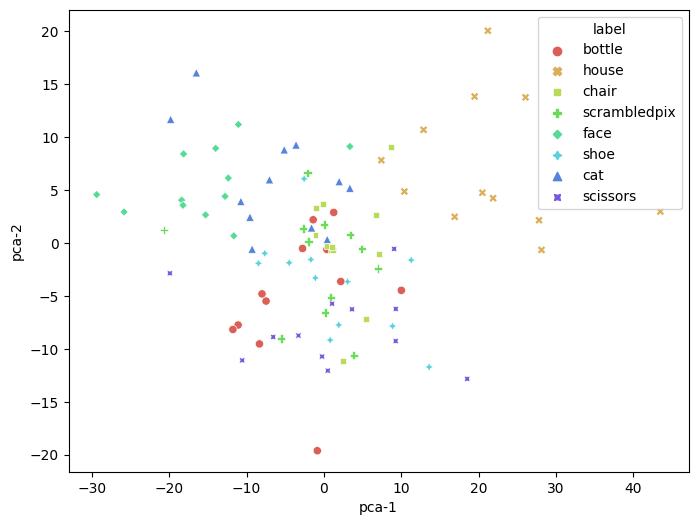

In [40]:
pca_df = pd.DataFrame(
    pca_results, columns=['pca-1', 'pca-2'])
pca_df['label'] = all_y

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="pca-1", y="pca-2",
    hue="label",
    style='label',
    palette=sns.color_palette("hls", 10),
    data=pca_df,
    legend="full",
    alpha=1
)

In [41]:

tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300)
tsne_results = tsne.fit_transform(all_X_fsel)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 96 samples in 0.000s...
[t-SNE] Computed neighbors for 96 samples in 0.168s...
[t-SNE] Computed conditional probabilities for sample 96 / 96
[t-SNE] Mean sigma: 9.640735
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.038582
[t-SNE] KL divergence after 300 iterations: 0.735434


/tmp/ipykernel_39356/3465833773.py:6: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.scatterplot(


<AxesSubplot: xlabel='tsne-1', ylabel='tsne-2'>

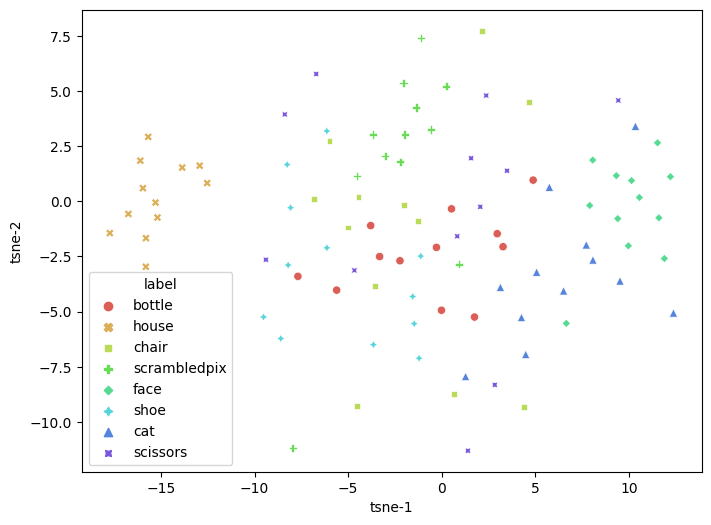

In [42]:
tsne_df = pd.DataFrame(
    tsne_results, columns=['tsne-1', 'tsne-2'])
tsne_df['label'] = all_y

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue="label",
    style='label',
    palette=sns.color_palette("hls", 10),
    data=tsne_df,
    legend="full",
    alpha=1
)